In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import util.munge as munge
import util.visualizations as viz

import warnings
warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [57]:
def import_cdc_data(filename:str, column_headers=None):
    df = pd.read_csv(filename, parse_dates=[0])
    df.drop(["Footnote", "Start week", "End Week"], axis=1, inplace=True)
    if column_headers is not None:
        df.columns = column_headers
    #cdc["covid_deaths"] = cdc["covid_19_deaths"] + cdc["pneumonia_and_covid_19_deaths"]
    df = df.rename(columns={"date_as_of":"date"})
    return df.loc[df["state"] != 'United States']

# import cdc data
cdc3 = import_cdc_data("data/cdc_deaths_by_race_age_20200603.csv")
cdc10 = import_cdc_data("data/cdc_deaths_by_race_age_20200610.csv", cdc3.columns) 

cdc10.head()

,date,state,age_group,race_and_ethnicity,covid_19_deaths,total_deaths,pneumonia_deaths,pneumonia_and_covid_19_deaths,influenza_deaths,pneumonia_influenza_or_covid_19_deaths
97,2020-06-10,Alabama,Under 1 year,Non-Hispanic White,0.0,40.0,0.0,0.0,0.0,0.0
98,2020-06-10,Alabama,1-4 years,Non-Hispanic White,0.0,16.0,0.0,0.0,NaN,NaN
99,2020-06-10,Alabama,5-14 years,Non-Hispanic White,0.0,22.0,NaN,0.0,0.0,NaN
100,2020-06-10,Alabama,15-24 years,Non-Hispanic White,0.0,102.0,NaN,0.0,0.0,NaN
101,2020-06-10,Alabama,25-34 years,Non-Hispanic White,0.0,218.0,NaN,0.0,NaN,NaN


In [58]:
def import_our_data(date=None):
    df = pd.read_csv("data/Race Data Entry - Tracker Commits.csv", parse_dates=["date"])
    df = df.drop([col for col in df.columns if "Unnamed" in col], axis=1) \
        .drop([col for col in df.columns if "positives" in col], axis=1) \
        .drop([col for col in df.columns if "negatives" in col], axis=1) \
        .drop(["last_check","update_time"], axis=1)
    df["state"] = df["state"].map(munge.state_full_names)
    if date:
        df = df.loc[df["date"] == date]
    return df

ours = import_our_data()
ours3 = import_our_data("2020-06-03")
ours10 = import_our_data("2020-06-10")

ours10_race_eth_cols = [col for col in ours10.columns 
                        if ("deaths" in col) and not ("percent" in col) and not ("unknown" in col) 
                        and (col != "total_deaths")]

ours10.loc[ours["state"] == "Alabama"].sort_values("date").head()

,date,state,total_deaths,deaths_white,deaths_black,deaths_latinx,deaths_asian,deaths_aian,deaths_nhpi,deaths_multiracial,deaths_other,deaths_race_unknown,deaths_percent_race_unknown,deaths_hispanic,deaths_nonhispanic,deaths_ethnicity_unknown,deaths_percent_ethnicity_unknown
1,2020-06-10,Alabama,744.0,360.0,333.0,NaN,5.0,NaN,NaN,NaN,12.0,34.0,5%,18.0,640.0,86.0,12%


In [59]:
cdc3["race_and_ethnicity"].unique()

array(['Non-Hispanic White', 'Non-Hispanic Black',
       'Non-Hispanic American Indian or Alaska Native',
       'Non-Hispanic Asian',
       'Non-Hispanic Native Hawaiian or Other Pacific Islander',
       'Non-Hispanic More than one race', 'Hispanic or Latino', 'Unknown'],
      dtype=object)

## Are there states where only one of us (CDC or CRDT) have data?

In [60]:
ours10_completeness = ours10[["state"] + ours10_race_eth_cols].sort_values("state")
ours10_completeness["total_data_points"] = ours10_completeness.notnull().sum(axis=1)
ours10_completeness.set_index("state", inplace=True)
ours10_completeness["no_data"] = [row["total_data_points"] == 0 for i, row in ours10_completeness.iterrows()]

In [62]:
cdc10_completeness = cdc10.groupby(["state", "race_and_ethnicity"])["covid_19_deaths"].sum() \
    .reset_index(name="death_count") \
    .pivot(index="state", columns="race_and_ethnicity", values="death_count")
cdc10_completeness["total_data_points"] = cdc10_completeness.notnull().sum(axis=1)
cdc10_completeness["total_data_points_zero"] = cdc10_completeness.replace(0, np.nan).isna().sum(axis=1)

cdc10_completeness["no_data"] = [row["total_data_points_zero"] == 8 for i, row in cdc10_completeness.iterrows()]

Ok, a few things here. So the CDC reports 0 even when they DON'T have data, evidenced by several states having 0 covid deaths recorded for every race. So I'm looking to see which states we don't have data for and comparing that to which states the CDC recorded 0 deaths across all races.

In [63]:
data_completeness = cdc10_completeness[["no_data"]].merge(
    ours10_completeness[["no_data"]],
    how="outer",
    left_index=True,
    right_index=True,
    suffixes=["_cdc", "_crdt"]
)
data_completeness.loc[data_completeness["no_data_cdc"] != data_completeness["no_data_crdt"]]

,no_data_cdc,no_data_crdt
state,,
Alaska,True,False
American Samoa,NaN,False
Guam,NaN,False
Hawaii,True,False
Montana,True,False
New York City,False,NaN
Northern Mariana Islands,NaN,False
Virgin Islands,NaN,False
Wyoming,True,False


## Are states sharing data uniformly in the CDC dataset?

In [62]:
ours10_combined = ours10.loc[ours10["positives_latinx"].notnull() | ours10["deaths_latinx"].notnull()]
ours10_separate = ours10.loc[ours10["positives_latinx"].isnull() & ours10["deaths_latinx"].isnull()]

In [65]:
print(f"CRDT States reporting race only: {ours10_combined.state.values}")
print(f"\nCRDT States reporting race and ethnicity: {ours10_separate.state.values}")

CRDT States reporting race only: ['Arizona' 'California' 'Colorado' 'Connecticut' 'District of Columbia'
 'Delaware' 'Florida' 'Georgia' 'Illinois' 'Massachusetts' 'Maryland'
 'Mississippi' 'New Hampshire' 'New Jersey' 'New Mexico' 'Nevada'
 'New York' 'Rhode Island' 'South Dakota' 'Texas' 'Washington' 'Wyoming']

CRDT States reporting race and ethnicity: ['Alaska' 'Alabama' 'Arkansas' 'American Samoa' 'Guam' 'Hawaii' 'Iowa'
 'Idaho' 'Indiana' 'Kansas' 'Kentucky' 'Louisiana' 'Maine' 'Michigan'
 'Minnesota' 'Missouri' 'Northern Mariana Islands' 'Montana'
 'North Carolina' 'North Dakota' 'Nebraska' 'Ohio' 'Oklahoma' 'Oregon'
 'Pennsylvania' 'Puerto Rico' 'South Carolina' 'Tennessee' 'Utah'
 'Virginia' 'Virgin Islands' 'Vermont' 'Wisconsin' 'West Virginia']


## Does the CRDT Data Align with the CDC's Data?

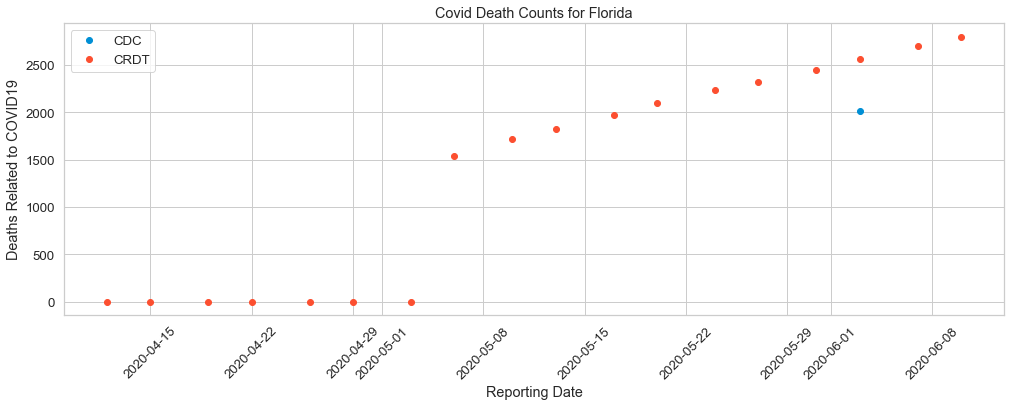

In [37]:
state = "Florida"

cdc_to_plot = cdc3.groupby(["state", "date"])["covid_19_deaths"].sum().reset_index()
cdc_to_plot = cdc_to_plot.loc[cdc_to_plot["state"] == state]
cdc_to_plot["date"] = pd.to_datetime(cdc_to_plot["date"]).dt.date
ours_to_plot = ours.groupby(["state", "date"])["total_deaths"].sum().reset_index()
ours_to_plot = ours_to_plot.loc[ours_to_plot["state"] == state]

fig, ax = plt.subplots(figsize=(15,5))
ax.plot_date(cdc_to_plot["date"], cdc_to_plot["covid_19_deaths"], label="CDC")
ax.plot_date(ours_to_plot["date"], ours_to_plot["total_deaths"], label="CRDT")
plt.xticks(rotation=45)
plt.xlabel("Reporting Date")
plt.ylabel("Deaths Related to COVID19")
plt.title(f"Covid Death Counts for {state}")
plt.legend()
plt.show()

## Are there any outliers in race data reporting at the state level?

This data is pretty different. We're comparing apples to oranges really. So let's do 2 things:

1. If we aggregate the totals per state for each reported metric, how similar are we?
2. On a state-by-state basis, let's come up with a low-ball high-ball range for what the reported race numbers could be. We won't really know if we are right on, so can we tell if the numbers are completely off?

### Total Deaths

In [38]:
to_plot_cdc = cdc10.replace("New York City", "New York") \
    .groupby(["date","state"])["covid_19_deaths"].sum() \
    .reset_index(name="cdc_total_deaths")[["state", "cdc_total_deaths"]]

to_plot_ours = ours10[["state", "total_deaths"]]
to_plot_ours.columns = ["state", "crdt_total_deaths"]

to_plot = to_plot_cdc.merge(to_plot_ours, how="outer", on="state")

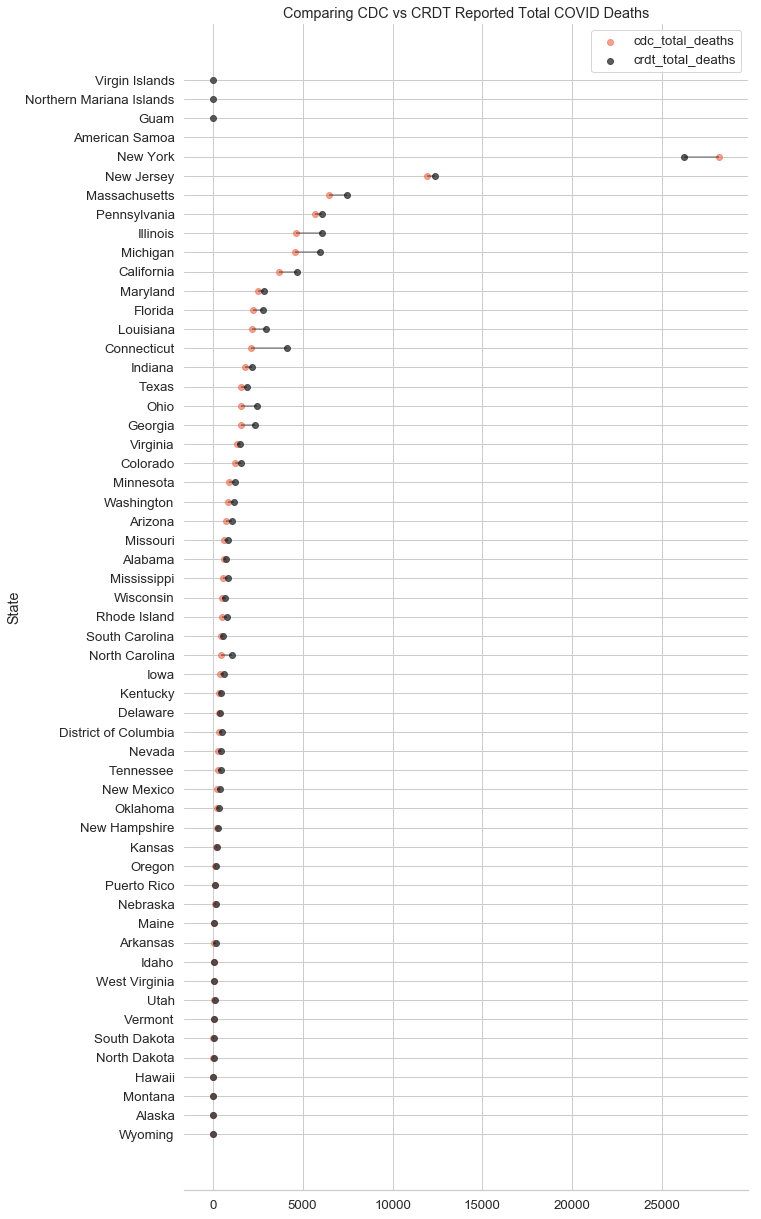

In [39]:
viz.state_level_metric_diff(to_plot, "cdc_total_deaths", "crdt_total_deaths", log=False,
                            plot_title="Comparing CDC vs CRDT Reported Total COVID Deaths")

### Deaths by Race

In [51]:
to_plot_cdc = cdc10.where(cdc10["race_and_ethnicity"] == "Non-Hispanic Black") \
    .replace("New York City", "New York") \
    .groupby(["date","state"])["covid_19_deaths"].sum() \
    .reset_index(name="cdc_deaths_black")[["state", "cdc_deaths_black"]]

to_plot_ours = ours10[["state", "deaths_black"]]
to_plot_ours.columns = ["state", "crdt_deaths_black"]

to_plot = to_plot_cdc.merge(to_plot_ours, how="outer", on="state")
to_plot = to_plot.loc[~to_plot["state"].isin(["Virgin Islands", "Northern Mariana Islands", "Guam", "American Samoa"])]

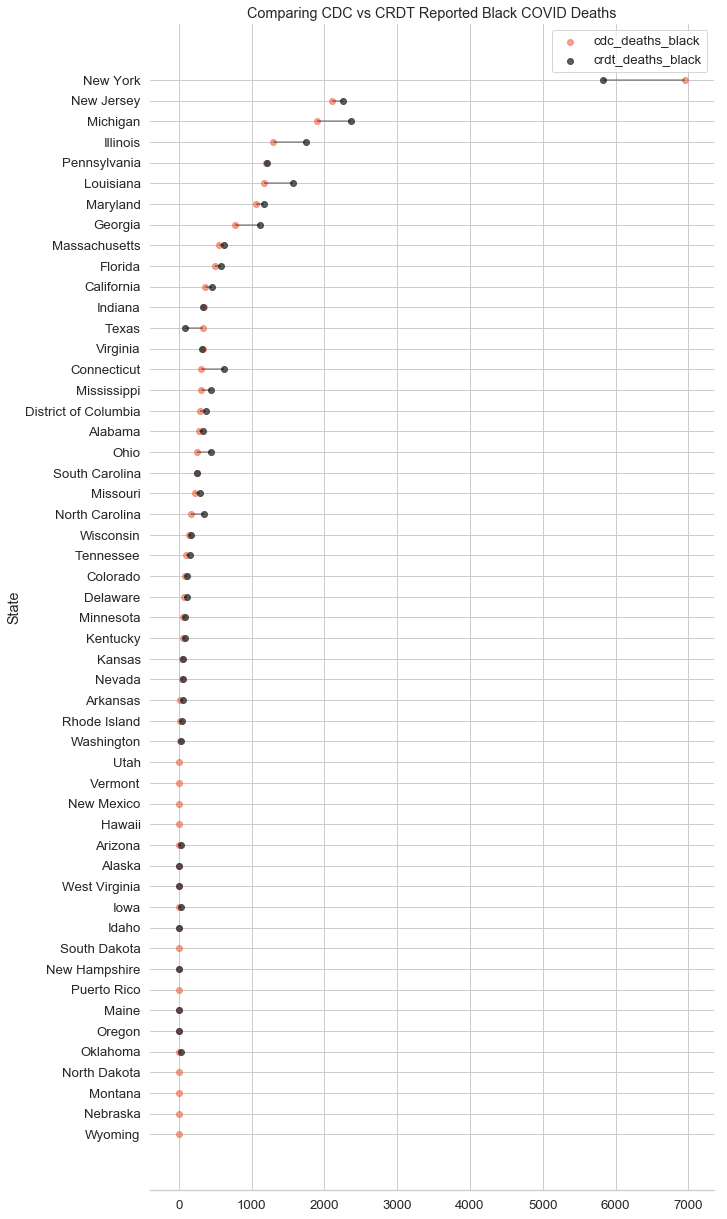

In [52]:
viz.state_level_metric_diff(to_plot, "cdc_deaths_black", "crdt_deaths_black", log=False,
                            plot_title="Comparing CDC vs CRDT Reported Black COVID Deaths")

In [50]:
to_plot_ours.loc[to_plot_ours["state"] == "South Dakota"]

,state,crdt_deaths_black
45,South Dakota,NaN


In [58]:
cdc10.loc[cdc10["state"] == "Utah"]

,date_as_of,state,age_group,race_and_ethnicity,covid_19_deaths,total_deaths,pneumonia_deaths,pneumonia_and_covid_19_deaths,influenza_deaths,pneumonia_influenza_or_covid_19_deaths
4057,2020-06-10,Utah,Under 1 year,Non-Hispanic White,0.0,68.0,NaN,0.0,0.0,NaN
4058,2020-06-10,Utah,1-4 years,Non-Hispanic White,0.0,NaN,0.0,0.0,0.0,0.0
4059,2020-06-10,Utah,5-14 years,Non-Hispanic White,0.0,17.0,0.0,0.0,0.0,0.0
4060,2020-06-10,Utah,15-24 years,Non-Hispanic White,0.0,67.0,NaN,0.0,NaN,NaN
4061,2020-06-10,Utah,25-34 years,Non-Hispanic White,0.0,134.0,NaN,0.0,NaN,NaN
4062,2020-06-10,Utah,35-44 years,Non-Hispanic White,0.0,208.0,NaN,0.0,NaN,NaN
4063,2020-06-10,Utah,45-54 years,Non-Hispanic White,NaN,328.0,14.0,NaN,NaN,21.0
4064,2020-06-10,Utah,55-64 years,Non-Hispanic White,NaN,660.0,28.0,NaN,NaN,39.0
4065,2020-06-10,Utah,65-74 years,Non-Hispanic White,16.0,1107.0,65.0,10.0,NaN,77.0
4066,2020-06-10,Utah,75-84 years,Non-Hispanic White,17.0,1633.0,103.0,NaN,NaN,120.0


In [56]:
to_plot.where(to_plot["state"] == "Utah")

,state,cdc_deaths_black,crdt_deaths_black
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
5,NaN,NaN,NaN
6,NaN,NaN,NaN
7,NaN,NaN,NaN
8,NaN,NaN,NaN
9,NaN,NaN,NaN
